In [2]:
#%matplotlib
import numpy as np
pi = np.pi
import scipy.io as spio
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from qutip import *

from matplotlib import animation, rc
from IPython.display import HTML

# Figures should have a width of a 8.6 cm or 3 3/8 in, the width of a single manuscript column.
golden_mean = (np.sqrt(5)-1.0)/2.0 # Aesthetic ratio
fig_width = 3+3/8 # width in inches
fig_height = fig_width*golden_mean # height in inches (0.75 is the standard height to width ratio in Python)
fig_size = [fig_width, fig_height]
mpl.rcParams.update({
    'axes.labelsize' : 12,
    'font.size' : 12,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'ytick.minor.pad' : -0.5,
    'ytick.minor.pad' : -0.5,
    'ytick.major.size' : 1,
    'ytick.minor.size' : 1,
    'ytick.major.width' : .5,
    'ytick.minor.width' : .5,
    'xtick.major.size' : 1,
    'xtick.minor.size' : 1,
    'xtick.major.width' : .5,
    'xtick.minor.width' : .5,
    'xtick.major.pad' : 1.5,
    'xtick.minor.pad' : 1.5,
    'text.usetex' : True,
    'figure.dpi' : 100,
})

#### This notebook is based on https://arxiv.org/abs/1605.03250v1

## TOC:
* [KNR](#intro)
* [Deterministic preparation of a cat state](#first-bullet)
* [$R_z(\phi)$-gate](#second-bullet)
* [$R_x(\theta)$-gate](#third-bullet)
* [$U(\Theta)$-gate](#fourth-bullet)

# Universal quantum computation with Kerr Nonlinear Oscillators (KNR) <a class="anchor" id="intro"></a>
In the present model, we use a KNR for each qubit. 

In a frame rotating at half the pump frequency of the parametric drive and in the rotating-wave approximation, the Hamiltonian for a KNR is given by

$$
H_1/\hbar = \Delta a^\dagger a + \frac{K}{2}a^{\dagger 2} a^2-\frac{G}{2}(a^{\dagger 2}+a^2).
$$

Here $\Delta$ is the detuning of the eigenfrequency from half the pump frequency. We assume that $K$ is a positive constant and that $\Delta$ is nonnegative.

We will discuss how the following gates are implemented
$$
\begin{align}
    R_z(\phi) &= e^{-i\phi Z/2} = 
    \begin{pmatrix}
    e^{-i\phi/2} & 0 \\
    0 & e^{i\phi/2}
    \end{pmatrix}
    \\
    R_x(\theta) &= e^{-i\theta X/2} = 
    \begin{pmatrix}
    \cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\
    -i\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{pmatrix}
    \\
    R_y(\theta) &= e^{-i\theta Y/2} = 
    \begin{pmatrix}
    \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
    \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{pmatrix}
    \\
    U(\Theta) &= e^{-i\Theta Z_1Z_2/2} = 
    \begin{pmatrix}
    e^{-i\Theta/2} & 0 & 0 & 0 \\
    0 & e^{i\Theta/2} & 0 & 0 \\
    0 & 0 & e^{i\Theta/2} & 0 \\
    0 & 0 & 0 & e^{-i\Theta/2} \\
    \end{pmatrix}
\end{align}
$$

## Deterministically preparation of a cat state <a class="anchor" id="first-bullet"></a>
A cat state of the KNR is generated deterministically as follows. The KNR is initially prepared in the vacuum state $|0\rangle$. Then, $G$ is increased sufficiently slowly from zero. Since $|0\rangle$ is the ground state for the initial Hamiltonian, the KNR adiabatically follows the instantaneous ground state of the Hamiltonian. When $\Delta = 0$, the ground state is doubly degenerate and the eigenspace is spanned by two coherent states $|\pm \alpha\rangle$ where $\alpha=\sqrt{G/K}$. Since $H_1$ is symmetric under parity inversion $a \rightarrow −a$, the final state should have the same parity as the initial state $|0\rangle$. Thus, the final state is the even cat state defined as
$$
|C_+\rangle = \frac{|\alpha\rangle+|-\alpha\rangle}{\sqrt{2(1+e^{-2\alpha^2})}}
$$
When $G$ is so large compared to $K$ such that $e^{−2\alpha^2}$ is negligible, the two coherent states $|\pm\alpha\rangle$ are orthogonal to each other. Taking a value $\alpha$ such that $e^{-2\alpha^2}$ is negligible, we define the computational basis states, $|\bar 0\rangle$ and $|\bar 1\rangle$, of a qubit as two coherent states $|\alpha\rangle $ and $|-\alpha\rangle$, respectively, where we have used the bars to distinguish the computational basis states from the vacuum and single-photon states of the KNR.

Fidelity = 99.98 %


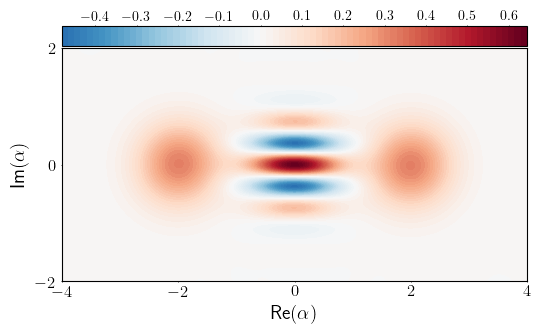

In [23]:
num_lvl = 20 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # kerr amplitude
G = 4 # two-photon pump amplitude
alpha = pow(G/K,1/2) # coherent state eigenvalue        self.set_up_ops()SE
SE


# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

def H1_coeff(t,args):
    tau = args['tau']
    return t/tau

H0 = K/2 * pow(a.dag(),2)*pow(a,2)
H1 = - G/2 * (pow(a.dag(),2) + pow(a,2))
H_tot = [H0,[H1,H1_coeff]]

psi0 = basis(num_lvl,0) # vacuum
tlist = np.linspace(0,150,500)
rho = mesolve(H_tot, psi0, tlist, c_ops=[], e_ops=[], args = {'tau': tlist[-1]})
rho_final = rho.states[-1]

# Wigner function
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(rho_final,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

# fidelity
cat = (up + down).unit()
f = fidelity(cat,rho_final)
print('Fidelity = %s %%' %round(f*100,2))

After this initialization, the pump amplitude $G$ is kept constant during the quantum computation.

## $R_z(\phi)$ on a qubit <a class="anchor" id="second-bullet"></a>
To perform $R_z(\phi)$ on a qubit, we drive the KNR by a driving field with a pulse-shaped amplitude $E(t)$. Then, the additional Hamiltonian is given by
$$
    H_z(t)/\hbar = E(t)(a+a^\dagger)
$$
When $|E(t)|\ll 4G$ and the variation of $E(t)$ is sufficiently slow, the KNR is approximately kept in the computational basis. The single photon drive results in energy shifts for $|\bar 0\rangle$ and $|\bar 1\rangle$, which are $2E(t)\alpha$ and $-2E\alpha$ respectively. These energy shifts induce dynamical phase factors, and conseequently $R_z(\phi)$ is performed, where $\phi$ is given by ($T_g$ is the gate time)
$$
    \phi = 4 \alpha \int_0^{T_g} E(t)dt.
$$
In the simulations below we set $\Delta = 0$ and $G=4K$ so that $\alpha = 2$. We pereform $R_z(\phi)$ on the initial state $(|\bar 0 \rangle + |\bar 1\rangle)/\sqrt{2}$ and calculate the fidelity between the output state in the simulation with the ideal output state $(e^{-i\phi/2}|\bar 0 \rangle + e^{i\phi/2}|\bar 1\rangle)$. 

To perform $R_z(\phi)$, $E(t)$ is set as
$$
    E(t) = \frac{\pi \phi}{8T_g\alpha}\sin\frac{\pi t}{T_g}
$$

In [2]:
num_lvl = 20 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # kerr amplitude
G = 4*K # two photon pump amplitude
alpha = np.sqrt(G/K) # amplitude
T_g = 2/K # gate time

cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()

# sigma z
sigma_z = up*up.dag() - down*down.dag()

# initial state
psi0 = (up+down).unit()

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*t/T_g)

def rz(phi):
    return (-1j*phi/2*sigma_z).expm()

# Hamiltonian
H0 = - K * pow(a.dag(),2)*pow(a,2) + G * (pow(a.dag(),2) + pow(a,2))
H1 = a.dag() + a
H_tot = [H0,[H1,E]]

# time array
tlist = np.linspace(0,T_g,200)

phi_list = np.linspace(-np.pi,np.pi,20)

In [25]:
f = []
for phi in phi_list:
    # Master equation solver
    rho = mesolve(H_tot, psi0, tlist, c_ops = [c_ops], e_ops = [], args = {'phi': phi})
    rho_final = rho.states[-1]
    target_state = rz(phi) * psi0
    f.append(fidelity(target_state,rho_final))

### Plot
It is found that high fidelities are achieved for $\phi$ in the range $-\pi$ to $\pi$. The fidelity becomes higher for longer gate time.

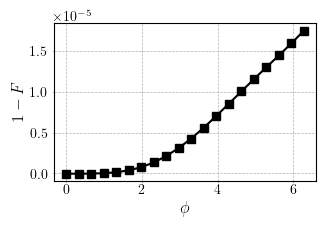

In [17]:
plt.figure(figsize=fig_size)
plt.plot(phi_list,1-np.array(f),'sk-')
plt.xlabel(r'$\phi$');
plt.ylabel(r'$1-F$');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=False)
#plt.savefig('figs/fig-rz-infidelity.pdf', dpi=300, transparent=False, bbox_inches='tight')

### Average gate fidelity of $R_z(\phi)$
(Not sure if I calculate this correctly.)

In [3]:
phi = np.pi
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()
# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

gamma = 1/1500
c_ops = np.sqrt(gamma)*a
def avg_gate_fid(U,args):
    sigma = [I, sigma_x, sigma_y, sigma_z]
    d = 2
    F = 0
    for sigma_j in sigma:
        epsilon = mesolve(H_tot, sigma_j, tlist, c_ops = [], e_ops = [], args = args)
        F = F + abs((U*sigma_j*U.dag()*epsilon.states[-1]).tr())        
    return (F + d**2) / (d**2*(d+1)) 

# Unitary matrix to into qubit frame
U_rot = (1j*H0*T_g).expm()

avg_fid = []
for phi in phi_list:
    avg_fid.append(avg_gate_fid(rz(phi),args = {'phi': phi}))

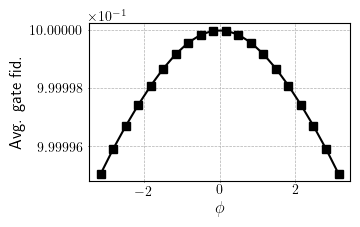

In [5]:
plt.figure(figsize=fig_size)
plt.plot(phi_list,np.array(avg_fid),'s-k')
plt.xlabel(r'$\phi$');
plt.ylabel(r'Avg. gate fid.');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(0,0), useMathText=False)
plt.savefig('figs/fig-avg-gate-fid-rz.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [5]:
gamma = 1/250
phi = 0
c_ops = np.sqrt(gamma)*a
prop = propagator(H_tot, tlist, c_op_list = [c_ops], args = {'phi': phi})
kraus_form = to_kraus(prop[-1])
d = 2
target = rz(phi)
(d + np.sum([np.abs((A_k * target.dag()).tr())**2 for A_k in kraus_form])) / (d**2 + d)

1.149242418434015

In [ ]:
gamma = 1/250
phi = 0
c_ops = np.sqrt(gamma)*a
prop = propagator(H_tot, tlist, c_op_list = [c_ops], args = {'phi': phi})
kraus_form = to_kraus(prop[-1])
d = 2
target = rz(phi)
sigma = [I, sigma_x, sigma_y, sigma_z]
d = 2
F = 0
for sigma_j in sigma:
    F = F + abs((U*sigma_j*U.dag()*(A_k*sigma_j*A_k.dag())).tr())        
return (F + d**2) / (d**2*(d+1)) 

(d + np.sum([np.abs((A_k * target.dag()).tr())**2 for A_k in kraus_form])) / (d**2 + d)

In [ ]:
A = propagator(H_tot, tlist, c_op_list = [c_ops], args = {'phi': phi})

## Dis da shit!

In [30]:
opt = Options(nsteps=1e4)
A = propagator(H_tot, T_g, c_op_list = [c_ops], args = {'phi': 0}, options = opt)

In [16]:
  Subst# TRUE AVG GATE FID!
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()
# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def avg_gate_fid(oper,target):
    sigma = [I, sigma_x, sigma_y, sigma_z]
    d = 2
    F = 0
    kraus_form = to_kraus(oper)
    for sigma_j in sigma:
        epsilon = sum([A_k*sigma_j*A_k.dag() for A_k in kraus_form])
        F = F + abs((target*sigma_j.dag()*target.dag()*epsilon).tr())        
    return (F + d**2) / (d**2*(d+1)) 

phi = 0
i = 0
avg_fid = []
for phi in phi_list:
    i += 1
    print(i)
    target = rz(phi)
    A = propagator(H_tot, tlist, c_op_list = [c_ops], args = {'phi': phi})
    avg_fid.append(avg_gate_fid(A[-1],target))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [11]:
phi = np.pi
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()
# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

gamma = 1/250
c_ops = np.sqrt(gamma)*a
def avg_gate_fid(U,prop):
    sigma = [I, sigma_x, sigma_y, sigma_z]
    d = 2
    F = 0
    for sigma_j in sigma:
        F = F + abs((U*sigma_j.dag()*U.dag()*(prop*sigma_j*prop.dag())).tr())
    return (F + d**2) / (d**2*(d+1)) 

avg_fid = []
for phi in phi_list:
    prop = propagator(H_tot, tlist, c_op_list = [c_ops], args = {'phi': phi})
    avg_fid.append(avg_gate_fid(rz(phi), prop[-1]))

a
tjosan
here


TypeError: Incompatible Qobj shapes

## $R_x(\theta)$ on a qubit <a class="anchor" id="first-bullet"></a>
To perform $R_x(\theta)$ on a qubit, we use the detuning $\Delta$. When $\Delta$ is slowly increased from zero to a value $\Delta_0$ near to $G$ and then decreased to zero, the even and odd cat states, obtain dynamical phase factors depending on their energy shifts due to the nonzero detuning. Thus the qubits change as follow ($\theta$ is the phase difference between the even and odd cat state)
$$
\begin{align}
\alpha_0|\bar 0\rangle +  \alpha_1|\bar 1 \rangle =& \frac{\alpha_0+\alpha_1}{2}(|\bar 0\rangle + |\bar 1 \rangle)
\frac{\alpha_0-\alpha_1}{2}(|\bar 0\rangle - |\bar 1 \rangle) \\
\rightarrow & \frac{\alpha_0+\alpha_1}{2}(|\bar 0\rangle + |\bar 1 \rangle)
\frac{\alpha_0-\alpha_1}{2}e^{i\theta}(|\bar 0\rangle - |\bar 1 \rangle) \\
=&  e^{-i\theta/2}\left[\left(\alpha_0\cos\frac{\theta}{2}-i\alpha_1\sin\frac{\theta}{2}\right)|\bar 0 \rangle 
+ \left(\alpha_1\cos\frac{\theta}{2}-i\alpha_0\sin\frac{\theta}{2}\right)|\bar 1 \rangle \right] \\
=& e^{-i\theta/2}R_x(\theta)(\alpha_0|\bar 0\rangle +\alpha_1|\bar 1\rangle)
\end{align} 
$$
Thus $R_x(\theta)$ is achieved by this detuning protocol.

Below we present numerical simulations. In the simulations below we set $G = 4K$ and $T_g = 10/K$, the initial state $|\psi_i\rangle$ is set to $(|\bar 0\rangle +i|\bar 1\rangle)/\sqrt{2}$ and the Hilbert space is truncated to a photon number of $16$. The detuning protocol is controlled as follows
$$
\Delta(t) = \Delta_0\sin^2\frac{\pi t}{T_g}.
$$

In [14]:
num_lvl = 30 # number of levels
K = 1
a = destroy(num_lvl) # annihilation operator
G = 4 # two photon pump amplitude
alpha = np.sqrt(G) # amplitude
T_g = 10/K # gate time

cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# initial state
psi0 = up #(up+1j*down).unit()

# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()

# detuning
def Delta(t,args):
    Delta_0 = args['Delta_0']
    return Delta_0 * pow(np.sin(np.pi*t/T_g),2)

def rx(theta):
    return (-1j*theta/2*sigma_x).expm()

# Hamiltonian
H0 = - K * pow(a.dag(),2)*pow(a,2) + G * (pow(a.dag(),2) + pow(a,2))
H1 = - a.dag()*a
H_tot = [H0,[H1,Delta]]

### Find the best $\theta$ with respect to average gate fidelity

In [38]:
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
# list with pauli matrices
sigma = [I, sigma_x, sigma_y, sigma_z]

# collapse operators
gamma = 1/250
c_ops = np.sqrt(gamma)*a

# time array
tlist = np.linspace(0,T_g,200)

# angle array
theta_list = np.linspace(0,np.pi,180)

# amplitude array
Delta_0_list = np.linspace(0,3.95,20)

max_f = [] # max fidelity
max_theta = [] # max angle
# For precise calculation
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8)
for Delta_0 in Delta_0_list:
    d = 2
    f = []
    epsilon = []
    for sigma_j in sigma:
        e = mesolve(H_tot, sigma_j, tlist, c_ops = [], e_ops = [], options=opt, args = {'Delta_0' : Delta_0})
        epsilon.append(e.states[-1])
    # find the theta that maximize the avg gate fidelity    
    for theta in theta_list:
        U = rx(theta) # target state
        F = 0
        for idx, rho in enumerate(epsilon):
            F = F + abs((U*sigma[idx]*U.dag()*rho).tr())
        f.append((F + d**2) / (d**2*(d+1)))
    max_theta.append(theta_list[np.argmax(f)])
    max_f.append(np.max(f))

### Find the best $\theta$ with respectto fidelity of a specific input state

In [15]:
# time array
tlist = np.linspace(0,T_g,200)

# angle array
theta_list = np.linspace(0,np.pi,180)

# amplitude array
Delta_0_list = np.linspace(0,4,12)

max_f = []
max_theta = []
gamma = 0
for Delta_0 in Delta_0_list:
    # Master equation solver
    rho = mesolve(H_tot, psi0, tlist, c_ops = [], e_ops = [], args = {'Delta_0': Delta_0})
    rho_final = rho.states[-1]
    f = [] # fidelity
    for theta in theta_list:
        target_state = rx(theta) * psi0
        f.append(fidelity(target_state, rho_final))
    max_theta.append(theta_list[np.argmax(f)])
    max_f.append(np.max(f))

### Plot
To estimate the rotation angle $\theta$ corresponding to $\Delta_0$, we calculated the fidelity between the output state in the simulation and $R_x(\theta)|\psi_i\rangle$, and found $\theta$ maximizing the fidelity. The results are shown below, where $F$ denotes the maximized fidelity.

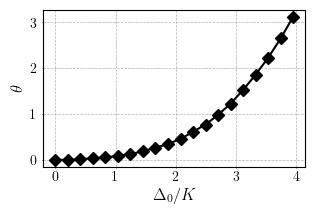

In [44]:
plt.figure(figsize=fig_size);
#plt.subplot(211)
plt.plot(Delta_0_list, max_theta, 'kD-');
plt.grid(linestyle='--', linewidth=.5);
plt.xlabel(r'$\Delta_0/K$');
plt.ylabel(r'$\theta$');
plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(0,0), useMathText=False);
plt.savefig('figs/fig-arg-rx.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
"""
plt.subplot(212)
plt.plot(max_theta,np.array(max_f), 'ks-')
plt.xlabel(r'$\theta$');
plt.ylabel(r'Avg. gate fid.');
#plt.ylabel(r'$1-F$');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(0,0), useMathText=False)
#plt.savefig('figs/fig-rx-infidelity.pdf', dpi=300, transparent=False, bbox_inches='tight')
"""

We see that when $\Delta_0$ changes from $0$ to $3.96 K$, the rotation angle $\theta$ changes from $0$ to $\pi$.

## Average gate fidelity of $R_x(\theta)$

In [13]:
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()
# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

gamma = 1/1500
c_ops = np.sqrt(gamma)*a
def avg_gate_fid(U,args):
    d = 2
    sigma = [I, sigma_x, sigma_y, sigma_z]
    F = 0
    for sigma_j in sigma:
        epsilon = mesolve(H_tot, sigma_j, tlist, c_ops = [c_ops], e_ops = [], args = args)
        F = F + abs((U*sigma_j*U.dag()*epsilon.states[-1]).tr())
    return (F + d**2) / (d**2*(d+1)) 

avg_fid = []
for i, Delta_0 in enumerate(Delta_0_list):
    avg_fid.append(avg_gate_fid(rx(max_theta[i]),args = {'Delta_0': Delta_0}))

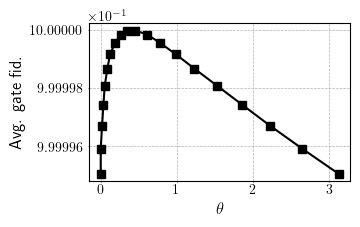

In [43]:
plt.figure(figsize=fig_size)
plt.plot(max_theta,np.array(avg_fid),'s-k')
plt.xlabel(r'$\theta$');
plt.ylabel(r'Avg. gate fid.');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(0,0), useMathText=False)
plt.savefig('figs/fig-avg-gate-fid-rx.pdf', dpi=300, transparent=False, bbox_inches='tight')

## $R_y(\theta)$ on a qubit <a class="anchor" name="ry"></a>
so perform $R_y(\theta)$ on a qubit, we turn off the two-photon drive and let the state evolve freely under the Kerr Hamiltonian during a time $\pi/2K$ before being turned on again but this time with negative amplitude. This corresponds changing to the Y-basis.

In [10]:
num_lvl = 24 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G0 = 4
alpha = np.sqrt(G0) # amplitude
T_g = 2 # gate time of Rz
L = np.pi/2 # gate time H
t_total = 2*L+T_g

cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def ry(theta):
    return (-1j*theta/2*sigma_y).expm()

# initial state
psi = (up+down).unit()

# Time independent Hamiltonian
H0 = K * pow(a.dag(),2)*pow(a,2) - G0 * (a.dag()**2 + a**2)

# Time depentent Hamiltonians
H1 = G0 * (a.dag()**2 + a**2)
H2 = 1j*(a - a.dag())

# two photon pump amplitude
def G(t,args):
    # Square pulse of length L and amplitude a centered at (b+L/2)
    A = (np.heaviside(L - t, 0) + 2*(np.heaviside(t - L, 0) - np.heaviside(t - (T_g+L), 0)) + np.heaviside(t - (T_g+L), 0))
    return A

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*(t-L)/T_g)*(np.heaviside(t-L,0)-np.heaviside(t-(T_g+L),0))

# total Hamiltonian
H_tot = [H0,[H1,G],[H2,E]]

# time array
tlist = np.linspace(0,t_total,1000)

# Master equation solver
phi_list = np.linspace(0,np.pi,20)

In [20]:
f = []
gamma = 0
for phi in phi_list:
    rho = mesolve(H_tot, psi, tlist, c_ops = [], e_ops = [], options = opt, args = {'phi': phi})
    rho_final = rho.states[-1]
    target_state = ry(phi) * psi
    f.append(fidelity(target_state,rho_final))

### Plot
The simulation results are shown below.

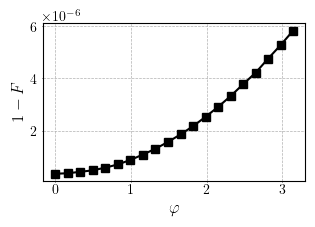

In [21]:
plt.figure(figsize=fig_size)
plt.plot(phi_list,1-np.array(f),'s-k')
plt.xlabel(r'$\varphi$');
plt.ylabel(r'$1-F$');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=False)
#plt.savefig('fig-ry-infidelity.pdf', dpi=300, transparent=False, bbox_inches='tight')

## Average gate fidelity $R_y(\varphi)$

In [11]:
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()
# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

gamma = 1/1500
c_ops = np.sqrt(gamma)*a
# For precise calculation
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8)
def avg_gate_fid(U,args):
    d = 2
    sigma = [I, sigma_x, sigma_y, sigma_z]
    F = 0
    for sigma_j in sigma:
        epsilon = mesolve(H_tot, sigma_j, tlist, c_ops = [c_ops], e_ops = [], options=opt, args = args)
        F = F + abs((U*sigma_j*U.dag()*epsilon.states[-1]).tr())
    return (F + d**2) / (d**2*(d+1)) 

avg_fid = []
for phi in phi_list:
    avg_fid.append(avg_gate_fid(ry(phi),args = {'phi': phi}))

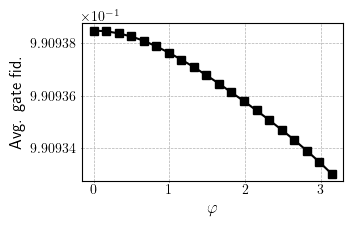

In [13]:
plt.figure(figsize=fig_size)
plt.plot(phi_list,np.array(avg_fid),'s-k')
plt.xlabel(r'$\varphi$');
plt.ylabel(r'Avg. gate fid.');
plt.grid(linestyle='--',linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(0,0), useMathText=False)
plt.savefig('figs/fig-avg-gate-fid-noisy-real-ry.pdf', dpi=300, transparent=False, bbox_inches='tight')

# Two qubit gate $U(\Theta)$ <a class="anchor" id="fourth-bullet"></a>
To perform $U(\Theta)$ on two qubits, we control the coupling coefficient $g(t)$ between the two KNRs. The additional Hamiltonian is given by
$$
H_U/\hbar = g(t)(a_1 a_2^\dagger + a_1^\dagger a_2)
$$
This is the standard linear coupling which describes photon exchange between two KNRs. When $|g(t)|$ is sufficiently small and the variation of $g(t)$ is sufficiently slow, the KNRs are approximately kept in the subspace spanned by $|\bar 0\rangle |\bar 0 \rangle$, $|\bar 0\rangle |\bar 1 \rangle$, $|\bar 1\rangle |\bar 0 \rangle$ and $|\bar 1\rangle |\bar 1 \rangle$. Then the energy shifts for $|\bar 0\rangle |\bar 1 \rangle$ and $|\bar 1\rangle |\bar 0 \rangle$ is $-2g(t)\alpha^2$. These energy shifts induce dynamical phase factors, and consequently $U(\Theta)$ is performed, where $\Theta$ is given by ($T_g$ is the gate time)
$$
\Theta = 4\alpha^2\int_0^{T_g}g(t)dt.
$$
In the numerical simulations below we set the parameters $G=4K$, $\Delta=0$, and $T_g=2/K$, the initial state is set to $|\psi_i\rangle = (|\bar 0 \rangle + |\bar 1 \rangle)(|\bar 0 \rangle + |\bar 1 \rangle)/2$, and the Hilbert space is truncated at a photon number of $16$ for each KNR. We perform $U(\Theta)$ on $|\psi_i\rangle$ and calculate the fidelity between thee output state in the simulation and the ideal output state $U(\Theta)|\psi_i\rangle$. To perform $U(\Theta)$, we set $g(t)$ as
$$
g(t) = \frac{\pi\Theta}{8T_g\alpha^2}\sin\frac{\pi t}{T_g}
$$

In [3]:
# In units of K
num_lvl = 16 # number of levels
a = destroy(num_lvl) # annihilation operator
eye = qeye(num_lvl) # identity operator
a1 = tensor([a,eye])
a2 = tensor([eye,a])
K = 1
G = 4 # two photon pump amplitude
alpha = np.sqrt(G) # coherent state amplitude
T_g = 2 # gate time

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# sigma z
sigma_z = ket2dm(up) - ket2dm(down)
sigma_z1 = tensor([sigma_z,eye])
sigma_z2 = tensor([eye,sigma_z])

# sigma y
sigma_y = down*up.dag() - 1j * up*down.dag()
sigma_y1 = tensor([sigma_y,eye])
sigma_y2 = tensor([eye,sigma_y])

# initial state
psi0 = tensor([up+down,up+down]).unit()

# coupling
def g(t,args):
    Theta = args['Theta']
    return np.pi*Theta/(8*T_g*pow(alpha,2))*np.sin(np.pi*t/T_g)

# ideal gate
def U(Theta):
    return (-1j*Theta/2*sigma_z1*sigma_z2).expm()
    
# Hamiltonian
H1 = K * pow(a1.dag(),2)*pow(a1,2) - G * (pow(a1.dag(),2) + pow(a1,2))
H2 = K * pow(a2.dag(),2)*pow(a2,2) - G * (pow(a2.dag(),2) + pow(a2,2))
H_coupling = a1.dag()*a2 + a2.dag()*a1
H_tot = [(H1+H2),[H_coupling,g]]

# time list
tlist = np.linspace(0,T_g,200)

Theta_list = np.linspace(0,2*np.pi,20) # angle array

In [9]:
f = [] # fidelity

for Theta in Theta_list:
    # Master equation solver
    rho = mesolve(H_tot, psi0, tlist, c_ops = [], e_ops = [], args = {'Theta': Theta})
    rho_final = rho.states[-1]
    target_state = U(Theta) * psi0
    f.append(fidelity(target_state,rho_final))

### Plot
The simulation results are shown below.

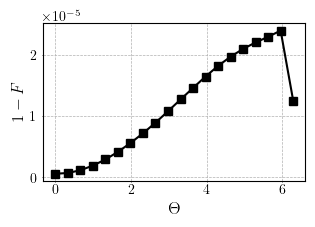

In [10]:
plt.figure(figsize=fig_size)
plt.plot(Theta_list, 1-np.array(f), 'ks-')
plt.xlabel(r'$\Theta$');
plt.ylabel(r'$1-F$');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=False)
#plt.savefig('figs/fig-U-infidelity.pdf', dpi=300, transparent=False, bbox_inches='tight')

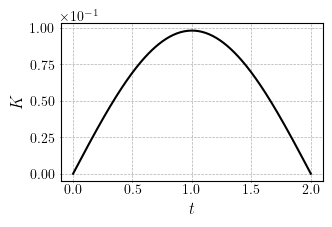

In [18]:
plt.figure(figsize=fig_size)
plt.plot(tlist, g(tlist,{'Theta': 2}), 'k-')
plt.xlabel(r'$t$');
plt.ylabel(r'$K$');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=False)

It is found that high fidelities are achieved for $\Theta$ in the range $0$ to $\pi$. The fidelities become higher for longer gate times.

## Average gate fidelity $U(\Theta)$

In [6]:
Theta = pi/2
avg_gate_fid(U(Theta),args = {'Theta': Theta})

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


0.9999882519580371

In [5]:
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()
# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

gamma = 1/1500
c_ops = [np.sqrt(gamma) * a1, np.sqrt(gamma) * a2]

def avg_gate_fid(U,args):
    sigma = [I,sigma_x, sigma_y, sigma_z]
    d = 4
    F = 0
    for sigma_i in sigma:
        for sigma_j in sigma:
            print('a')
            sigma_ij = tensor(sigma_i,sigma_j)
            epsilon = mesolve(H_tot, sigma_ij, tlist, c_ops = [], e_ops = [], args = args)
            F = F + abs((U*sigma_ij.dag()*U.dag()*epsilon.states[-1]).tr())
    return (F + d**2) / (d**2*(d+1))

In [47]:
avg_fid = []
i = 0
for Theta in Theta_list:
    i += 1
    print(i)
    avg_fid.append(avg_gate_fid(U(Theta),args = {'Theta': Theta}))
np.save('data/avg-gate-fid-U',avg_fid)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


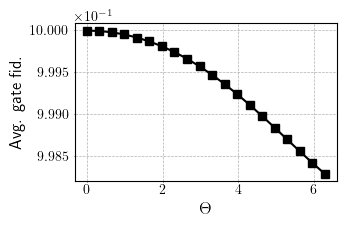

In [55]:
plt.figure(figsize=fig_size)
plt.plot(Theta_list,np.array(avg_fid),'s-k')
plt.xlabel(r'$\Theta$');  
plt.ylabel(r'Avg. gate fid.');
#plt.title(r'Average gate fidelity');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(-1,-1), useMathText=False)
plt.savefig('figs/fig-avg-gate-fid-U.pdf', dpi=300, transparent=False, bbox_inches='tight')

## Shruti Puri X-gate

In [3]:
num_lvl = 20 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G = 2*K # two photon pump amplitude
alpha = np.sqrt(G) # amplitude
Delta = K/50 # detuning
T_g = np.pi/(4*Delta*abs(alpha)**2*np.exp(-2*abs(alpha)**2)) # gate time
print('T_g',T_g)

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# initial state
psi0 = up

# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()

def rx(theta):
    return (-1j*theta/2*sigma_x).expm()

# Hamiltonian
H0 = Delta * a.dag()*a - K * pow(a.dag(),2)*pow(a,2) + G * (pow(a.dag(),2) + pow(a,2))

# time array
tlist = np.linspace(0,T_g,500)

opt = Options(nsteps=1e4)

# Master equation solver
rho = mesolve(H0, psi0, tlist, c_ops = [], e_ops = [], options = opt)
rho_final = rho.states[-1]
target_state = rx(np.pi) * psi0

f = fidelity(target_state,rho_final)
print('fidelity',f)

T_g 1072.032169023246
fidelity 0.9993848416979505


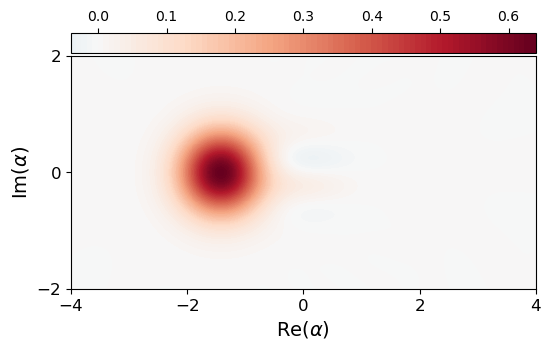

In [98]:
# Wigner function
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(rho_final,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')
#cbar.ax.xaxis.set_ticks_position('top')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

# Average gate fidelity

In [62]:
num_lvl = 20 # number of levels
a = destroy(num_lvl) # annihilation operator
alpha = 2

cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()

# sigma z
sigma_z = up*up.dag() - down*down.dag()

# sigma x
sigma_x = up*down.dag() + down*up.dag()

# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def avg_gate_fid(oper,target):
    d = 2 # qubit
    U = [sigma_x, sigma_y, sigma_z]
    F = (sum([(target * U_j.dag() * target.dag() * (U_j*oper*U_j.dag())).tr() for U_j in U]) + d**2) / (d**2*(d+1))
    return F

In [14]:
num_lvl = 24 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G0 = 4
alpha = np.sqrt(G0) # amplitude
t_total = 2

cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def ry(theta):
    return (-1j*theta/2*sigma_y).expm()

# initial state
psi = (up+down).unit()

# Time independent Hamiltonian
H0 = K * pow(a.dag(),2)*pow(a,2) + G0 * (a.dag()**2 + a**2)

# total Hamiltonian
H_tot = H0

# time array
tlist = np.linspace(0,t_total,1000)

psi = up

rho = mesolve(H_tot, psi, tlist)
rho_final = rho.states[-1]

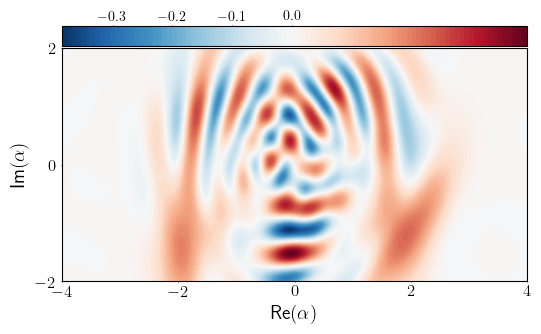

In [15]:
# Wigner function
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(rho_final,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')
#cbar.ax.xaxis.set_ticks_position('top')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

## Constant amplitude

In [49]:
# In units of K
num_lvl = 30 # number of levels
a = destroy(num_lvl) # annihilation operator
eye = qeye(num_lvl) # identity operator
a1 = tensor([a,eye])
a2 = tensor([eye,a])
K = 1
G = 4 # two photon pump amplitude
alpha = np.sqrt(G) # coherent state amplitude
T_g = 2 # gate time

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# sigma z
sigma_z = ket2dm(up) - ket2dm(down)
sigma_z1 = tensor([sigma_z,eye])
sigma_z2 = tensor([eye,sigma_z])

# sigma y
sigma_y = down*up.dag() - 1j * up*down.dag()
sigma_y1 = tensor([sigma_y,eye])
sigma_y2 = tensor([eye,sigma_y])

# initial state
psi0 = tensor([up+down,up+down]).unit()

# coupling
g = 0.05

# gate time
T_g = lambda Theta: Theta/(4*g*pow(alpha,2))

# ideal gate
def U(Theta):
    return (-1j*Theta/2*sigma_z1*sigma_z2).expm()
    
# Hamiltonian
H1 = K * pow(a1.dag(),2)*pow(a1,2) - G * (pow(a1.dag(),2) + pow(a1,2))
H2 = K * pow(a2.dag(),2)*pow(a2,2) - G * (pow(a2.dag(),2) + pow(a2,2))
H_coupling = g*(a1.dag()*a2 + a2.dag()*a1)
H_tot = [(H1+H2)+H_coupling]

In [50]:
f = [] # fidelity

Theta_list = np.linspace(0,2*np.pi,20) # angle array
opt = Options(nsteps=1e5)
for Theta in Theta_list:
    # Master equation solver
    rho = mesolve(H_tot, psi0, [0,T_g(Theta)], c_ops = [], e_ops = [], options = opt)
    rho_final = rho.states[-1]
    target_state = U(Theta) * psi0
    f.append(fidelity(target_state,rho_final))

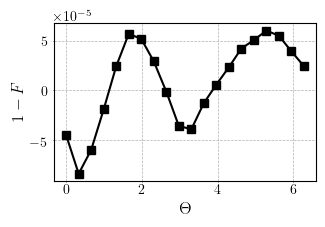

In [51]:
plt.figure(figsize=fig_size)
plt.plot(Theta_list, 1-np.array(f), 'ks-')
plt.xlabel(r'$\Theta$');
plt.ylabel(r'$1-F$');
plt.grid(linestyle='--', linewidth=.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=False)
#plt.savefig('figs/fig-U-infidelity.pdf', dpi=300, transparent=False, bbox_inches='tight')